In [1]:
import os, pickle, time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation as R
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
def altaz2xyz(alt,az):   
    sun = np.zeros((len(alt),3))
    sun[:,0] = np.cos(alt) * np.sin(az)
    sun[:,1] = np.cos(alt) * np.cos(az)
    sun[:,2] = np.sin(alt)
              
    return sun

In [3]:
def PVPower(pv_tilt_angle=0, E_area=1, W_area=1, T_area=1, horizon=0.0, lander_pitch=0, lander_roll=0, lander_yaw=0):
    #Lander orientation angles facing N.
    #Rotations applied in order: pitch, roll, yaw
    #Angles in degrees
    sun_rad = 0.265 #[degs] 
    
    #Grab precalculated alt, az, mjd for Jan 2025 lunar cycle
    #Gor LuSEE-Night landing site at (long, lat) = (182.25, -23.815)
    alt = np.loadtxt('alt_fullday.txt')
    az = np.loadtxt('az_fullday.txt')
    mjd = np.loadtxt('mjd_fullday.txt')
    alt_sun_top = np.asarray(alt)+sun_rad #For calculating sunrise/sunset integration limits for finite disk sun
    
    #Transitions
    iMidnight = np.argmin(alt)
    iSunrise = np.argmin(np.abs(alt[iMidnight:])) + iMidnight
    hrsFromSunrise = (mjd - mjd[iSunrise])*24
    
    sun = altaz2xyz(alt*np.pi/180, az*np.pi/180)#[day_mask]
    sun_top = altaz2xyz(alt_sun_top*np.pi/180, az*np.pi/180)#[day_mask]
    
    #Normal vector to a plane rotated pvRotAngle about  (S-N) axis
    pvRotAng = np.radians(pv_tilt_angle)
    EPVNormal = (np.cos(pvRotAng), 0., np.sin(pvRotAng))
    WPVNormal = (-np.cos(pvRotAng), 0., np.sin(pvRotAng))
    TPVNormal = (0., 0., 1.) #Vertical for top pannel

    #Define lander rotations
    r1 = R.from_euler('x', lander_pitch, degrees=True) # + is nose down, - is nose up
    r2 = R.from_euler('y', lander_roll, degrees=True) # + is top left, - is top right
    r3 = R.from_euler('z', lander_yaw, degrees=True) # + is nose right, - is nose left
    r_tot = r1*r2*r3

    #Rotate Lander
    EPVNormal_rot = r_tot.apply(EPVNormal)
    WPVNormal_rot = r_tot.apply(WPVNormal)
    TPVNormal_rot = r_tot.apply(TPVNormal)

    #Projected angle of sun on panels
    #Multiply by area of panels
    EPV_dot = E_area * np.dot(sun, EPVNormal_rot)
    WPV_dot = W_area * np.dot(sun, WPVNormal_rot)
    TPV_dot = T_area * np.dot(sun, TPVNormal_rot)
    TPV_dot_sun_top = T_area * np.dot(sun_top, TPVNormal_rot)

    #When dot product is negative, panel is not illuminated
    EPV_dot[EPV_dot<0]=0
    WPV_dot[WPV_dot<0]=0
    TPV_dot[TPV_dot<0]=0
    TPV_dot_sun_top[TPV_dot_sun_top<0]=0 #For finite disk at sunrise/sunset. Slight aprx: top of sun not center of segment
    
    #Power ignoring finite sun disk
    #EPV_power = np.where(np.logical_and((EPV_dot>0), (alt>horizon)), EPV_dot, 0)
    #WPV_power = np.where(np.logical_and((WPV_dot>0), (alt>horizon)), WPV_dot, 0)
    #TPV_power = np.where(np.logical_and((TPV_dot>0), (alt>horizon)), TPV_dot, 0)
    
    #Fraction of sun's disk that is above horizon
    #Area of a circular segment is:
    #A = r^2 arccos(1-h/r) - (r-h)*sqrt(r^2-(r-h)^2)
    #where r is radius and h is distance from edge of circle to chord (h by definition always less than radius)
    
    #Sun center above horizon: height of sun segment below horizon is h=sun_rad-alt
    #Sun center below horizon: height of sun segment above horzon is h=sun_rad-abs(alt)
    #A = (r**2)*np.arccos(1-((r-abs(alt))/r))-(r-(r-abs(alt)))*np.sqrt((r**2)-(r-(r-abs(alt)))**2)
    #A = (r**2)*np.arccos(1-((r-abs(alt))/r))-abs(alt)*np.sqrt((r**2)-(alt)**2)

    #Sanitize input to arccos and sqrt. Values where h<0 are non-physical and will be cut by condition_list.
    alt_seg = np.abs(alt)
    alt_seg[alt_seg>sun_rad]=sun_rad
    sun_seg_area = (sun_rad**2)*np.arccos(1-((sun_rad-alt_seg)/sun_rad))-alt_seg*np.sqrt((sun_rad**2)-(alt_seg)**2)
    sun_seg_frac = sun_seg_area/(np.pi*sun_rad**2)
      
    #Condictions are selected in order, as in an if-elif statement
    condition_list = [alt>horizon+sun_rad, alt>horizon, alt>horizon-sun_rad, alt<=horizon-sun_rad]
    
    #Full sun, subtract sun segment, add only sun segment, full disk below horizon
    EPV_choice_list = [EPV_dot, (1-sun_seg_frac)*EPV_dot, sun_seg_frac*EPV_dot, 0]
    WPV_choice_list = [WPV_dot, (1-sun_seg_frac)*WPV_dot, sun_seg_frac*WPV_dot, 0]
    TPV_choice_list = [TPV_dot, (1-sun_seg_frac)*TPV_dot, sun_seg_frac*TPV_dot_sun_top, 0]
    
    #Apply sunrise condition
    EPV_power = np.select(condition_list, EPV_choice_list)
    WPV_power = np.select(condition_list, WPV_choice_list)
    TPV_power = np.select(condition_list, TPV_choice_list)
  
    #Retrun power hitting east, west, and top PV panels. Normalized to 1 at normal incidence.   
    return hrsFromSunrise, EPV_power, WPV_power, TPV_power

### grab precalculated alt, az, mjd for Jan 2025 lunar cycle   
for LuSEE-Night landing site at (long, lat) = (182.25, -23.815)

Text(0, 0.5, 'Sun Altitude [deg]')

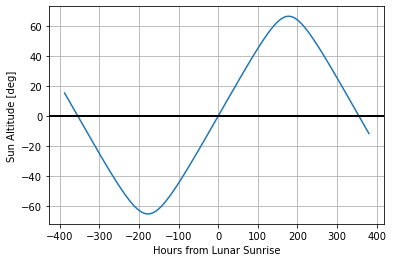

In [4]:
alt = np.loadtxt('alt_fullday.txt')
az = np.loadtxt('az_fullday.txt')
mjd = np.loadtxt('mjd_fullday.txt')

# transitions
iMidnight = np.argmin(alt)
iNoon = np.argmax(alt)
iSundown1 = np.argmin(np.abs(alt[:iMidnight]))
iSunrise = np.argmin(np.abs(alt[iMidnight:])) + iMidnight
iSundown2 = np.argmin(abs(alt[iNoon:])) + iNoon
hrsFromSunset = (mjd - mjd[iSundown1])*24
hrsFromSunrise = (mjd - mjd[iSunrise])*24
t_inc = 0.25 #Varies! But approx 0.25hrs ticks

#print(iMidnight)
#print(iNoon)
#print(iSundown1)
#print(iSunrise)
#print(iSundown2)

alt_sun_top = np.asarray(alt)+0.265
iSuntoprise = np.argmin(np.abs(alt_sun_top[iMidnight:iNoon])) + iMidnight
iSuntopdown2 = np.argmin(abs(alt_sun_top[iNoon:])) + iNoon

# plot altitude through the cycle
# plt.plot(hrsFromSunset,alt, label='Alt')
plt.plot(hrsFromSunrise,alt, label='Alt')
plt.axhline(0, c='k', lw=2)
plt.grid(True)
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Sun Altitude [deg]")

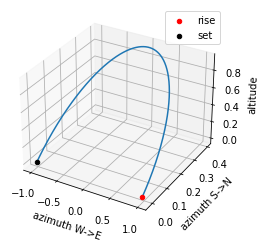

In [5]:
# plot track of sun in 3D during 1 lunar day
ax = plt.axes(projection='3d')
# day_mask = alt > 0
day_mask = [False]*len(alt) | (alt>0)
for i in range(len(day_mask)):
    if (i<iMidnight):
        day_mask[i] = False

sun = altaz2xyz(alt*np.pi/180, az*np.pi/180)
sunDay = altaz2xyz(alt*np.pi/180, az*np.pi/180)[day_mask]

ax.plot3D(sunDay[:,0],sunDay[:,1],sunDay[:,2])
ax.scatter3D(sunDay[0,0],sunDay[0,1],sunDay[0,2], c='r', label='rise')
ax.scatter3D(sunDay[-1,0],sunDay[-1,1],sunDay[-1,2], c='k', label='set')

ax.set_xlabel('azimuth W->E')
ax.set_ylabel('azimuth S->N')
ax.set_zlabel('altitude')
ax.legend()

### Explore effect of angle and area distribution  

####Single E&W tilt angle, plot components


Total Integrated Power: 1886.51
Fraction of Max Power:  0.741
TPV power integrated: 0.584
0.5824814154720733


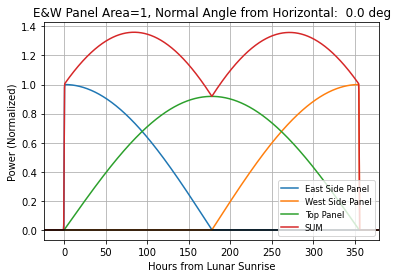

In [6]:
#Plot PV power at pv_tilt_angle
pv_tilt_angle=0
day_hrs, EPV_power, WPV_power, TPV_power = PVPower(pv_tilt_angle=pv_tilt_angle)

plt.plot(day_hrs, EPV_power, label='East Side Panel')
plt.plot(day_hrs, WPV_power, label='West Side Panel')
plt.plot(day_hrs, TPV_power, label='Top Panel')
plt.plot(day_hrs, EPV_power + WPV_power + TPV_power, label='SUM')

plt.axhline(0, c='k')
plt.grid()
plt.xlim(-24, 379)   # don't plot night
plt.legend(loc="lower right", fontsize="small")
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Power (Normalized)")
plt.title("E&W Panel Area=1, Normal Angle from Horizontal:  " + str(round(np.degrees(pv_tilt_angle),2)) + " deg")

#Total power integrated over day
power_tot = sum(EPV_power+WPV_power+TPV_power)
print(f"Total Integrated Power: {power_tot:.2f}")
print(f"Fraction of Max Power: {power_tot/2544.8947428752654: .3f}")  # max power when PVRotAngle = 90
print(f"TPV power integrated: {TPV_power[day_mask].sum()/len(TPV_power[day_mask]):.3f}")
print(2/np.pi * np.cos(np.radians(-23.8))) # this should equal TPV power integrated

#### Area redistribution

(Text(0.5, 0, 'Side Fraction'), Text(0, 0.5, 'Integrated Power'))

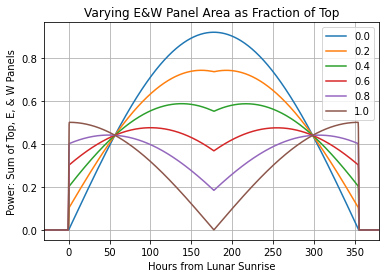

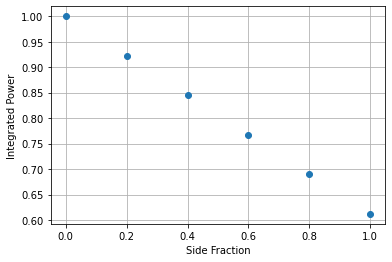

In [7]:
#Plot sum of top + side panel power at pv_tilt_angle, for varying side panel area 

#Vary side panel area from 0 to 1 (TPV area) in steps of 0.2
power_tot=[]
for sideArea in np.linspace(0, 1.0, 6):
    day_hrs, EPV_power, WPV_power, TPV_power = PVPower(pv_tilt_angle=0, E_area=0.5*sideArea, W_area=0.5*sideArea, T_area=(1-sideArea))
    plt.plot(day_hrs, EPV_power + WPV_power + TPV_power, label=str(round(sideArea,2)))
    power_tot.append(sum(EPV_power + WPV_power + TPV_power))
    
plt.grid(True); plt.legend(loc="upper right")
plt.xlim(-30,380)
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Power: Sum of Top, E, & W Panels")
plt.title("Varying E&W Panel Area as Fraction of Top")

plt.figure()
plt.plot(np.linspace(0, 1.0, 6), np.array(power_tot)/np.amax(power_tot), 'o')
plt.grid(True); plt.xlabel('Side Fraction'), plt.ylabel('Integrated Power')

#### Side Panel Tilt

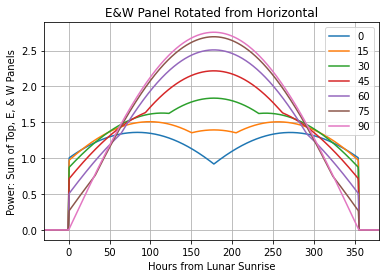

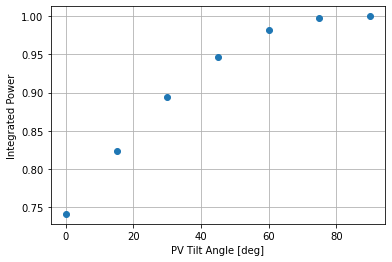

In [8]:
#Plot sum of top + side panel power at range of rotation angles

#Plot power from top alone
#plt.plot(day_hrs, TPV_power, label="Top alone")

#Plot sum of top + side panels (equal areas) for side panels rotated about N-S axis
power_tot = []
for rotang in range(0,91,15):
    day_hrs, EPV_power, WPV_power, TPV_power = PVPower(pv_tilt_angle=rotang)
    plt.plot(day_hrs, EPV_power + WPV_power + TPV_power, label=str(rotang))
    power_tot.append(sum(EPV_power + WPV_power + TPV_power))

plt.grid(True); plt.legend(loc="upper right")
plt.xlim(-30,380)
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Power: Sum of Top, E, & W Panels")
plt.title("E&W Panel Rotated from Horizontal")

plt.figure()
plt.plot(range(0,91,15), np.array(power_tot)/np.amax(power_tot), 'o')
plt.grid(True); plt.xlabel('PV Tilt Angle [deg]'), plt.ylabel('Integrated Power');

---
### Battery state of charge  
model:  
>night load = constant (Spectrometer operating, radio powered down)   
>day load = instrument + RF_RX + RF_TX + PPT + battery charging inefficiency  
>>- battery charger (PPT) cannot start until panel produces more than 10W
>>- RF radio off until panel produces more than 35W   
>>- battery begins to charge when panel power > instrument + RF radio  
>>- charging power = (panel power - instrument - RF radio) * charging efficiency   
>>- excess power (to be dumped) is panel power - day load


#### Battery and PV panel parameters   

Text(0.5, 1.0, 'Lunar Surface Temperature')

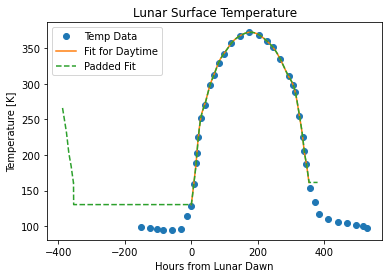

In [9]:
#Lunar surface temperature data
hrs_per_lunar_day = 2551443/3600
temp_data = np.loadtxt("lunarTemperature30degDiviner.txt", delimiter=',') #Data starts at midnight!
time=(temp_data[:,0]-6)/24*hrs_per_lunar_day; temp=temp_data[:,1] #-6hrs to shift to hours from sunrise
temp_fit = interp1d(time,temp,kind='cubic')

#Interpolate temp data over daylight hours with same spacing as day_hrs
#Edge pad to length of day_hrs so array size/time increments match
#Power outside daylight hours will be zero'd by PVPower func, so thermal eff value meaningless outside daylight
time_day = np.arange(0,hrs_per_lunar_day/2,t_inc) 
temp_matched = np.pad(temp_fit(time_day),(iSunrise+1,len(day_hrs)-iSundown2+2), mode='edge') 
#Copy end of day temps to previous day
temp_matched[:iSundown1] = temp_matched[(iSundown2-iSundown1):iSundown2]

plt.plot(time,temp,'o', label='Temp Data')
plt.plot(time_day, temp_fit(time_day), '-', label='Fit for Daytime')
plt.plot(day_hrs, temp_matched, '--', label='Padded Fit')
plt.legend()
plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Temperature [K]")
plt.title("Lunar Surface Temperature")


---
### Battery state of charge  
model:  
>night load = constant (Spectrometer operating, radio powered down)   
>day load = instrument + RF_RX + RF_TX + PPT + battery charging inefficiency  
>>- battery charger (PPT) cannot start until panel produces more than 10W
>>- RF radio off until panel produces more than 35W   
>>- battery begins to charge when panel power > instrument + RF radio  
>>- charging power = (panel power - instrument - RF radio) * charging efficiency   
>>- excess power (to be dumped) is panel power - day load


#### Shadow parameters   

300.0
Loading shadow fractions as function of azimuth angle...
Done!


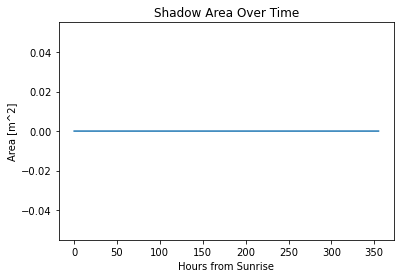

In [10]:
#Antenna Deployer Dimensions
#Model antenna deployers as thin vertical plates oriented E-W and N-S.
ant_hgt = 104 #[mm] height of deployer top above top PV
ant0_x0 = -200 #[mm] Ends of x-axis aligned antenna deployers, coordinate origin at center of LuSEE top
ant0_x1 = 200 #[mm]
ant0_y = 0 #[mm]
ant1_y0 = -200 #[mm] Ends of y-axis aligned antenna deployers
ant1_y1 = 200 #[mm]
ant1_x = 0 #[mm]
    
#LuSEE shape params    
lusee_side = 1000 #[mm] dimensions of LuSEE top panel
step_size = 10 #[mm] integration unit
lusee_x = np.arange(-lusee_side/2, lusee_side/2+step_size, step_size)
lusee_y = np.arange(lusee_side/2, -lusee_side/2-step_size, -step_size)
n_side = lusee_side/step_size

#Need to define geometry of PV panels
TPV_area = 0.6 #[m^2]
TPV_width = TPV_area*1e6/lusee_side/2 #[mm] For when PV is two stripes on sides of turntable

#Annulus around turntable
#PV_rad_inner = 200 #[mm] turntable radius
#if TPV_area < 0.7:
#    PV_rad_outer = np.sqrt((1/np.pi)*((TPV_area*n_side**2)+np.pi*PV_rad_inner**2))

#Shadow is parallelogram with area:
#A = ant_len * shadow_len
#Calculate edge vector for x-axis aligned deployers
alt_arr = np.asarray(alt*(np.pi/180))
az_arr = np.asarray(az*(np.pi/180))
shadow_edge_len = ant_hgt / np.tan(alt_arr) #edge length of shadow
x_dep_shadow_len = shadow_edge_len * -np.cos(az_arr) #length of x-axis deployer shadow projected in N-S direction

#Calculate edge vector for y-axis aligned deployers
y_dep_shadow_len = shadow_edge_len * -np.sin(az_arr) #length of y-axis deployer shadow projected in E-W direction

#plt.figure()
#plt.plot(day_hrs[iSunrise+25:iSundown2-25],x_shadow_len[iSunrise+25:iSundown2-25])
#plt.xlabel('hr'); plt.ylabel("y [mm]")
#plt.title("X-axis Deployer Shadow Length")

#Define fast vectorized greater-than func that works on 2D arrays
def array_gt(a, b):
    return a > b

#Magic vector speed up that avoids loops over arrays
vec_gt = np.vectorize(array_gt)

#Shadow calculation can take a long time, load from file if possible.
shadow_file = "./shadowed_area_E-W_stripes_0.35m2_"+str(step_size)+"mm_step"
if os.path.isfile(shadow_file):
    print("Loading shadow fractions as function of azimuth angle...")
    file = open(shadow_file,"rb")
    shadowed_area = pickle.load(file)
    file.close()
    print("Done!")
else:
    print("Calculating shadow fractions as function of azimuth angle...")
    start_time = time.time()
    shadowed_area = np.zeros([len(az_arr)])
    #Edge of shadows as function of (x,y) coords and sun azimuth
    x_edge = np.outer(lusee_y, np.tan(az_arr)) 
    y_edge = np.outer(lusee_x, 1/np.absolute(np.tan(az_arr)))
    
    xv, yv = np.meshgrid(lusee_x, lusee_y, indexing = 'xy') #Grid of Cartesian coordinates
    pixel_rad = np.sqrt(np.add.outer(lusee_x**2, lusee_y**2)) #For excluding turntable area
    #xy_PV = (pixel_rad > PV_rad_inner) #PV is all top panel outside turntable
    xy_PV = np.logical_or((yv < -lusee_side+TPV_width), (yv > lusee_side-TPV_width)) #PV is E-W oriented stripes N and S of turntable
 
    if not os.path.exists("./shadow_plots"):
        os.makedirs("./shadow_plots")

    plt.figure()
    plt.imshow(xy_PV, extent=[lusee_x[0], lusee_x[-1], lusee_y[-1], lusee_y[0]])
    plt.xlabel('x [cm]'); plt.ylabel("y [cm]")
    plt.title("PV Layout")
    plt.savefig("./shadow_plots/PV_layout")
    plt.close()   
    
    #plt.figure()
    #plt.plot(x_edge[:,iNoon+100], lusee_y)
    #plt.xlabel('x [mm]'); plt.ylabel("y [mm]")
    #plt.title("Shadow Edge")
              
    #Calculate which pixels fall into shadow at each time step
    for t in range(len(az_arr)):
        #Don't bother calculating shadows at night.
        if ((t > iSundown1) & (t < iSunrise)) | (t > iSundown2):
            shadowed_area[t] = 0 
        else:
            #Calculate which pixels fall into shadow cast by x-axis deployers
            #Shadow always falls south
            dummy, edge_xv = np.meshgrid(lusee_x, x_edge[:,t], indexing = 'xy')
            ax = vec_gt(xv, edge_xv+ant0_x0)
            bx = vec_gt(edge_xv+ant0_x1, xv)
            cx = vec_gt(ant0_y, yv)
            dx = vec_gt(yv, ant0_y+x_dep_shadow_len[t])
        
            #Calculate which pixels fall into shadow cast by y-axis deployers
            edge_yv, dummy = np.meshgrid(y_edge[:,t], lusee_y, indexing = 'xy')
            #Shadows before noon fall to west
            if (t > iSundown1) & (t < iNoon):
                ay = vec_gt(yv, edge_yv+ant1_y0)
                by = vec_gt(edge_yv+ant1_y1, yv)
                cy = vec_gt(ant1_x, xv)
                dy = vec_gt(xv, ant1_x+y_dep_shadow_len[t])
            #Shadows after noon fall to east
            else:
                ay = vec_gt(yv, -edge_yv+ant1_y0)
                by = vec_gt(-edge_yv+ant1_y1, yv)
                cy = vec_gt(xv, ant1_x)
                dy = vec_gt(ant1_x+y_dep_shadow_len[t], xv)
        
            x_dep_shadow = np.logical_and(np.logical_and(ax, bx), np.logical_and(cx, dx))
            y_dep_shadow = np.logical_and(np.logical_and(ay, by), np.logical_and(cy, dy))
            xy_shadow = np.logical_or(x_dep_shadow, y_dep_shadow)
            pv_shadow = np.logical_and(xy_PV, xy_shadow)
            shadowed_area[t]=pv_shadow.sum()
            #shadowed_area[t]=xy_shadow.sum()
 
            if not os.path.exists("./shadow_plots"):
                os.makedirs("./shadow_plots")
            
            plt.figure()
            plt.imshow(np.logical_not(xy_shadow), extent=[lusee_x[0], lusee_x[-1], lusee_y[-1], lusee_y[0]])
            plt.xlabel('x [mm]'); plt.ylabel("y [mm]")
            plt.title("Shadows at t="+str(t))
            plt.savefig("./shadow_plots/shadows_t"+str(t))
            plt.close()   
            
            plt.figure()
            plt.imshow(np.logical_not(pv_shadow), extent=[lusee_x[0], lusee_x[-1], lusee_y[-1], lusee_y[0]])
            plt.xlabel('x [mm]'); plt.ylabel("y [mm]")
            plt.title("Shadows on PV at t="+str(t))
            plt.savefig("./shadow_plots/pv_shadows_t"+str(t))
            plt.close()                                          
        
            if np.mod(t+1,100)==0:
                print(f"Evaluated time step: {(t+1)}, {(t+1)*100/len(az_arr):.2f}% complete.")
    
    file = open(shadow_file,"wb")
    pickle.dump(shadowed_area, file)
    file.close()
    print("Done! File saved.")

    print("Time to calculate: "+str(time.time()-start_time))
    
plt.figure()
plt.plot(day_hrs[iSunrise:iSundown2], shadowed_area[iSunrise:iSundown2]/n_side**2)
plt.xlabel('Hours from Sunrise'); plt.ylabel("Area [m^2]")
plt.title("Shadow Area Over Time")
    
shadowed_frac = shadowed_area/(TPV_area*n_side**2)

#### Battery and PV panel parameters   

In [11]:
fullCharge = 7000      # W-hr, 85% de-rating from EPT BOL 

solarConstant = 1361   # W/m^2 at Moon

# PANEL PARAMETERS
# PV_Efficiency = .2065  # solar-to-electrical, normal incidence, +126C, BOL, per Endurosat (N-G .32 BOL 23C)
#PV_Efficiency = .26      # rough average of Endurosat+N-G, intermediate temperature
PV_Efficiency = 0.3525   # efficiency of N-G PV at 270K, calculated from stated eff at 25C and 100C
PV_tempco_high = -0.0013 # efficiency change per K temp increase above 270K, calculated from N-G stated eff of ~0.22 at 100C
PV_tempco_low = -0.0005  # efficiency change per K temp decrease below 270K, calculated so max eff at 140K is 0.42
# PV_Fill = .676         # active area fraction, per Endurosat 16-cell panel (N-G .85 est.)
PV_Fill = .76            # average fo Endurosat + N-G
dustObscuration = 0.05    # fraction of area
radiationDegradation = 0.05
shadowingLoss = 0.05      # guesstimate; stacer base height ~ 70mm, average sun altitude ~39deg

#TPV_area = 0.35 * (1-shadowingLoss)     # top of 1x1x.7m outer enclosure minus area for turntable + comms
#EPV_area = 0.0 # m^2
#WPV_area = 0.0 # m^2
#TPV_area = 0.35
EPV_area = 0.175 # m^2
WPV_area = 0.175 # m^2

#Params from engineering model
#TPV_area = 0.709 * (1-shadowingLoss)     # top of 1x1x.7m outer enclosure minus area for turntable + comms
#EPV_area = 0.093 # m^2
#WPV_area = 0.093 # m^2

#Untipped Lander
day_hrs, EPV_power_unitless, WPV_power_unitless, TPV_power_unitless = PVPower(pv_tilt_angle=0, \
E_area=EPV_area, W_area=WPV_area, T_area=TPV_area, lander_pitch=0, lander_roll=0, lander_yaw=0)

#Apply shadows to TPV
#TPV_power_shadowed = np.multipy(TPV_power_unitless, (1-shadowed_frac))

#Worst Case
#day_hrs, EPV_power_unitless, WPV_power_unitless, TPV_power_unitless = PVPower(pv_tilt_angle=0, \
#E_area=EPV_area, W_area=WPV_area, T_area=TPV_area, lander_pitch=10, lander_roll=-10, lander_yaw=-10)

panelPeakPower = solarConstant * PV_Fill * (1-dustObscuration) * (1-radiationDegradation)
PV_tempco = np.where(temp_matched>270, PV_tempco_high, PV_tempco_low)
#PV_tempco = np.zeros(len(alt))
thermal_eff = PV_Efficiency + (PV_tempco * (temp_matched-270))
TPV_power = panelPeakPower * np.multiply.reduce((thermal_eff, 1-shadowed_frac, TPV_power_unitless))
EPV_power = panelPeakPower * np.multiply(thermal_eff, EPV_power_unitless)
WPV_power = panelPeakPower * np.multiply(thermal_eff, WPV_power_unitless)
panelPower = TPV_power + EPV_power + WPV_power

print(f"Top Panel Peak Power {TPV_power[iSunrise:].max():.2f}W")
print(f"East Side Panel Peak Power {EPV_power[iSunrise:].max():.2f}W")
# Estimate the peak power per m^2
print(f"Peak power per sq meter at normal incidence at 295K:  \
{panelPeakPower*PV_Efficiency:.3f}W")
print(f"Max panel power {panelPower.max():.2f}W")
max_pwr_time = round(day_hrs[np.where(np.logical_and((day_hrs>0), (panelPower == panelPower[iSunrise:].max())))[0][0]], 2)
print("Max power at "+str(max_pwr_time)+"hrs after sunrise")
print(f"Panel power at noon {panelPower[iNoon]:.2f}W")
# Note Endurosat data sheet says "up to 19.2W in LEO" for a 0.209m X 0.342m panel ==> 268.6W/m^2
# at efficiency "up to 30%"
# (consistent with ~193W/m^2 for 30% efficiency)
# implied tempco ~ -0.09%/degC

Top Panel Peak Power 113.01W
East Side Panel Peak Power 68.86W
Peak power per sq meter at normal incidence at 295K:  329.062W
Max panel power 129.06W
Max power at 100.5hrs after sunrise
Panel power at noon 113.01W


#### Load parameters   

In [12]:
# All powers in W
# Enumerate instrument power at night
# from subprocess import DETACHED_PROCESS

PPT_power = 6
PDU_power = 0.1
PFPS_power = 6
CDH_Power = 2
SPT_power = 5.64
Preamp_power = .78
charging_efficiency = 0.95
discharge_efficiency = 0.95
uncertainty_margin = 0.1    # approximates NTE
# nightPower = 17        # NTE; CBE = 15.27   
nightPower = (PDU_power + PFPS_power + CDH_Power + SPT_power + Preamp_power) / (discharge_efficiency) \
     * (1 + uncertainty_margin)
print(f"Instrument power before losses and inefficiency "
f"{PDU_power +PFPS_power + CDH_Power + SPT_power + Preamp_power:.2f} W")
print(f"Night power {nightPower:.3f} W\n with discharge efficiency of {discharge_efficiency:.2f}\n \
and uncertainty margin of {uncertainty_margin: .2f}")


RF_RX_Power = 5.3
RF_TX_Power = 13.7       # per KG email 10/26/22 i.e. RX+TX mode is 19W

# LPF PARAMETERS (email from F. Davarian 6/24/22)
avePassInterval = 14.118    # hours
avePassDuration = 5.7       # hours
stdPassInterval = 2.4       # hours
stdPassDuration = 0.1       # hours
RX_TX_avePower = RF_RX_Power + RF_TX_Power * (avePassDuration / avePassInterval)     # RX remains on
print(f"\nRF TX average duty factor {avePassDuration/avePassInterval:.3f}, \
     \nAverage power {RX_TX_avePower/discharge_efficiency:.2f} W incl. discharge efficiency")


Instrument power before losses and inefficiency 14.52 W
Night power 16.813 W
 with discharge efficiency of 0.95
 and uncertainty margin of  0.10

RF TX average duty factor 0.404,      
Average power 11.40 W incl. discharge efficiency


Cumulative Net Power During Daytime 27383.80W
Energy into Recharging Battery 5936.51Whrs
Excess Energy 21447.29Whrs
Average Load Power 25.34W
Minimum SOC 1054.7Whrs  (15.07% of Full Charge)
Recharge Time 84.25hrs
Energy Deficit 0.00Whrs



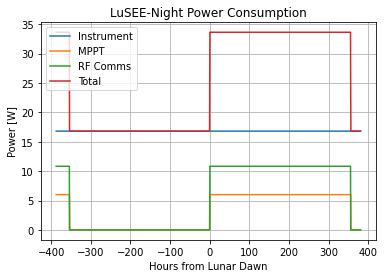

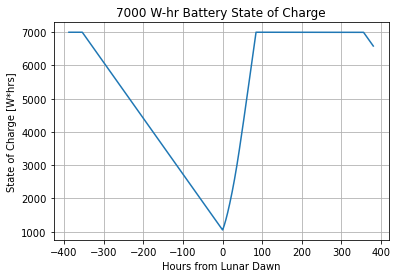

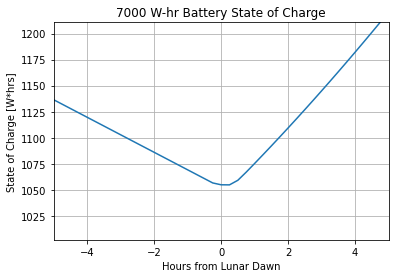

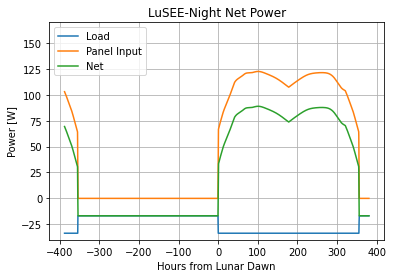

In [13]:
PPT_threshold = 10              # panel power to awaken PPT
radio_threshold = 35            # panel power to awaken radio
charging_mask = (panelPower > PPT_threshold) 
radio_mask = (panelPower > radio_threshold) 

loadPower = nightPower + PPT_power * charging_mask + RX_TX_avePower * radio_mask
netPower = (panelPower*charging_mask*charging_efficiency)-loadPower  # power available to charge battery

#check panel power
#plt.figure()
#plt.plot(day_hrs, panelPower, label="Panel Power")
#plt.plot(day_hrs, panelPower*charging_mask, label = "Power with Charging Mask")
#plt.legend()
#plt.title("Panel Power")

# Plot the components of daytime power
plt.figure()
plt.plot(day_hrs, np.ones_like(day_hrs) * nightPower, label='Instrument')
plt.plot(day_hrs, PPT_power*charging_mask, label = "MPPT")
plt.plot(day_hrs, RX_TX_avePower*radio_mask, label = "RF Comms")
plt.plot(day_hrs, np.ones_like(day_hrs) * nightPower + PPT_power * charging_mask + RX_TX_avePower*radio_mask, label = "Total")
plt.grid(True); plt.legend(); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Power [W]")
plt.title("LuSEE-Night Power Consumption")

# plot cumulative energy
#plt.figure()
#plt.plot(day_hrs, np.cumsum(loadPower/4.))
#plt.grid(True); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("W-hrs Cumulative")
#plt.title("LuSEE-Night Cumulative Energy Consumption")

#SOC = fullCharge + np.cumsum(netPower/4.)   # diff(day_hrs) = 0.25
#SOC = np.where(SOC>fullCharge, fullCharge, SOC)

#Calculate State of Charge
SOC = np.zeros(len(netPower))
SOC[0] = fullCharge #Start with battery full
excess_energy = 0
for index in range(len(netPower)-1):
    SOC[index+1] = min(SOC[index]+netPower[index]/4., fullCharge) #Don't overcharge battery
    if np.logical_and(index>iSunrise, SOC[index]+netPower[index]/4. > fullCharge):
        excess_energy = excess_energy + (SOC[index] + netPower[index]/4. - fullCharge)
    
#SOC
plt.figure()
#plt.plot(day_hrs, 100* SOC/fullCharge)
plt.plot(day_hrs, SOC)
plt.grid(True); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("State of Charge [W*hrs]")
plt.title("7000 W-hr Battery State of Charge")

#SOC Zoom
plt.figure()
plt.plot(day_hrs, SOC)
plt.xlim(-5, 5);
zoom_max = SOC[iSunrise-20:iSunrise+20].max()
zoom_min = SOC[iSunrise-20:iSunrise+20].min()
plt.ylim(0.95*zoom_min,1*zoom_max);
plt.grid(True); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("State of Charge [W*hrs]")
plt.title("7000 W-hr Battery State of Charge")

# Plot PV and load powers
fig, ax1 = plt.subplots()
ax1.plot(day_hrs, -1*loadPower, label='Load')
ax1.plot(day_hrs, panelPower*charging_mask*charging_efficiency, label='Panel Input')
ax1.plot(day_hrs, netPower, label='Net')
plt.ylim(-40, 170);
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.set_xlabel('Hours from Lunar Dawn')
ax1.set_ylabel("Power [W]")
ax1.set_title("LuSEE-Night Net Power")

#SOC [W]
#plt.figure(); plt.plot(day_hrs, SOC, label='Charge'); plt.axhline(SOC.min(), label='Min Charge', color = "red"); plt.ylim(0, 1.1*fullCharge); plt.grid(True)
#plt.legend(loc="lower right"); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Charge [W*hr]")
#plt.title("State of charge")

#Stats
print(f"Cumulative Net Power During Daytime {netPower[iSuntoprise:iSuntopdown2].sum()/4.:.2f}W")
print(f"Energy into Recharging Battery {netPower[iSuntoprise:iSuntopdown2].sum()/4.-excess_energy:.2f}Whrs")
print(f"Excess Energy {excess_energy:.2f}Whrs")
print(f"Average Load Power {loadPower.mean():.2f}W")
print(f"Minimum SOC {SOC.min():.1f}Whrs  ({100*SOC.min()/fullCharge:.2f}% of Full Charge)")
print(f"Recharge Time {day_hrs[np.where(np.logical_and((day_hrs>0), (SOC==SOC.max())))[0][0]]:.2f}hrs")
print(f"Energy Deficit {fullCharge-SOC[iSundown2]:.2f}Whrs")
print()

Text(0.5, 1.0, 'PV Thermal Efficiency')

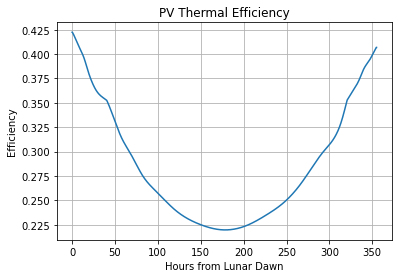

In [14]:
#PV Thermal Efficiency Plot
plt.figure()
plt.plot(day_hrs[iSunrise:iSundown2], thermal_eff[iSunrise:iSundown2])
plt.grid(True); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Efficiency")
plt.title("PV Thermal Efficiency")

Day Length:  355.2499999998836
Radio On:  354.9999999999418


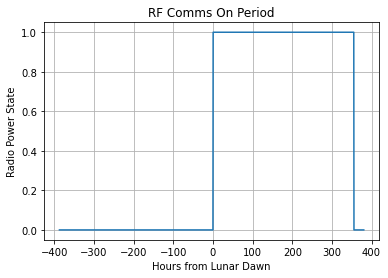

In [15]:
# plt.plot(day_hrs, radio_mask)
plt.grid(True)
plt.plot(day_hrs,day_mask*radio_mask)
plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Radio Power State")
plt.title("RF Comms On Period")

print("Day Length: ",day_hrs[iSundown2]-day_hrs[iSunrise])
print("Radio On: ",(day_hrs[day_mask*radio_mask]).max()-(day_hrs[day_mask*radio_mask]).min())